# Analisis de Genero por Semantica ESP

In [8]:
import matplotlib.pyplot as plt
import matplotlib as mpl
# import seaborn as sns

plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
get_ipython().run_line_magic('matplotlib', 'inline')

import os, sys
jiazz = os.path.abspath(os.path.join('..'))
print(jiazz)
if jiazz not in sys.path:
    sys.path.append(jiazz)
sys.path

/app


['',
 '/usr/local/lib/python36.zip',
 '/usr/local/lib/python3.6',
 '/usr/local/lib/python3.6/lib-dynload',
 '/usr/local/lib/python3.6/site-packages',
 '/usr/local/lib/python3.6/site-packages/IPython/extensions',
 '/root/.ipython',
 '/app']

In [9]:
from wordcloud import WordCloud, STOPWORDS

def generate_cloudword(pd, image_dims=(800, 400)):
    mpl.rcParams['font.size']=12                #10 
    mpl.rcParams['savefig.dpi']=100             #72 
    mpl.rcParams['figure.subplot.bottom']=.1 
    W, H = image_dims
    stopwords = set(STOPWORDS)
    data = pd

    wordcloud = WordCloud(
      background_color='white',
      stopwords=stopwords,
      max_words=250,
      max_font_size=40,
      width=W, height=H,
      random_state=777
     ).generate(str(data['sample']))

    fig = plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

### Create Load Function

In [10]:
from pandas import read_csv, DataFrame
from sklearn.utils import shuffle
from slugify import slugify


def load(filename):
    df = read_csv('../data/%s.csv' % filename)
    
    # df.loc[df.tag == 'f', 'tag'] = -1
    # df.loc[df.tag == 'm', 'tag'] = 1
    return shuffle(df)

In [11]:
df = load('gender_gramatical_spanish')
df.head()

sample tag
69811   @GloriaMonteneg @elcomercio_peru Moderese seño...   f
85220            puedes hablar en este momento unos 5 min   m
87719                                       para internet   m
18337                                         1 para 260    m
104279                                 O para comer algo    f

## Tokenize Words

In [12]:
from core import Jiazz as J


df['sample'] = df['sample'].apply(lambda x: J.stemmer(x))
df.head()

sample tag
69811   moderes seor cayend librer usa roj sl polit de...   f
85220                                pued habl moment min   m
87719                                            internet   m
18337                                                       m
104279                                                com   f

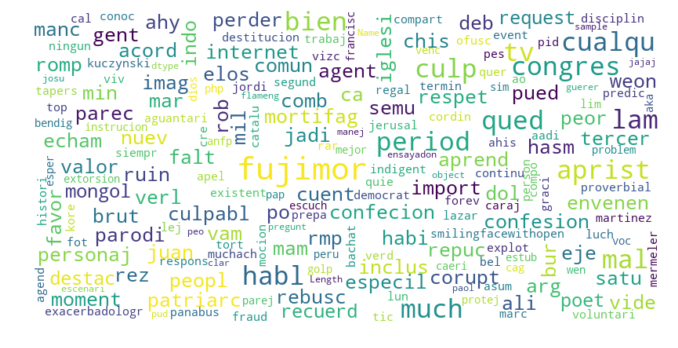

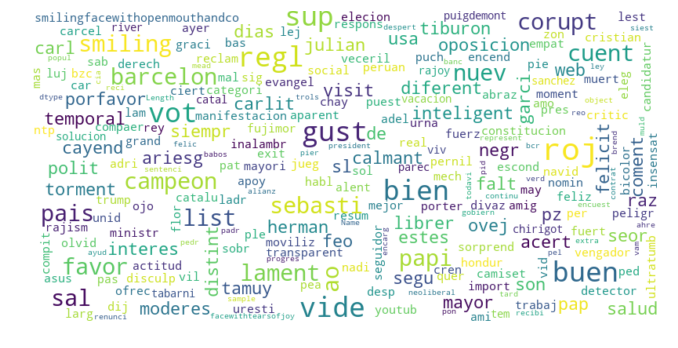

In [13]:
df_m = df[df['tag'] == 'm']
df_f = df[df['tag'] == 'f']

generate_cloudword(df_m)
generate_cloudword(df_f)

### Split Training Dataset

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

df = shuffle(df)

X, y = df['sample'], df['tag']

vect = TfidfVectorizer(use_idf=True, smooth_idf=False)

classes = df.tag.unique()
print(classes)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.15,
                                                    random_state=777)

['m' 'f']


### Entrenamiento

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.ensemble import AdaBoostRegressor
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import KFold
import numpy as np
from sklearn import cross_validation
from sklearn import metrics


alg = MultinomialNB()
alg = LinearSVC()
alg = Perceptron(n_jobs=-1, class_weight='balanced')
alg = LogisticRegression()
# alg = SGDRegressor()



pipe = Pipeline([('vec', vect), ("clf", alg)])
print('Run Logistic')

param_grid = dict(
    clf__C=[8, 1, 9],
    clf__fit_intercept=[False, False],
    clf__dual=[True, False],    
    
    #clf__n_estimators=[50],
    #clf__penalty=['l2'],
    #clf__alpha=[.1, .01],
    #clf__n_iter=[50, 100],    
    #clf__penalty=['l2', 'elasticnet'],
    # clf__fit_prior=[False, True],
    
    vec__ngram_range=[(1, 2), (1, 3)],
    vec__analyzer=['word'],
    vec__max_df=[0.75, .8],
    vec__norm=['l2'],
    vec__binary=[True],
    vec__use_idf=[True],
    vec__smooth_idf=[True]    
)


print("Performing grid search...")
print("pipeline:", [name for name, _ in pipe.steps])
print("parameters:")


shuffle_kfold = KFold(n_splits=4, shuffle=True)
grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=shuffle_kfold, verbose=5, n_jobs=24, scoring='accuracy')
grid_search.fit(X_train, y_train)



# shuffle_kfold = KFold(n_splits=4, shuffle=True)
# grid_search = GridSearchCV(pipe, param_grid=param_grid, verbose=5, n_jobs=24)
# grid_search.fit(X_train, y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Run Logistic
Performing grid search...
pipeline: ['vec', 'clf']
parameters:
Fitting 4 folds for each of 48 candidates, totalling 192 fits
[CV] clf__C=8, clf__dual=True, clf__fit_intercept=False, vec__analyzer=word, vec__binary=True, vec__max_df=0.75, vec__ngram_range=(1, 2), vec__norm=l2, vec__smooth_idf=True, vec__use_idf=True 
[CV] clf__C=8, clf__dual=True, clf__fit_intercept=False, vec__analyzer=word, vec__binary=True, vec__max_df=0.75, vec__ngram_range=(1, 2), vec__norm=l2, vec__smooth_idf=True, vec__use_idf=True 
[CV] clf__C=8, clf__dual=True, clf__fit_intercept=False, vec__analyzer=word, vec__binary=True, vec__max_df=0.75, vec__ngram_range=(1, 2), vec__norm=l2, vec__smooth_idf=True, vec__use_idf=True 
[CV] clf__C=8, clf__dual=True, clf__fit_intercept=False, vec__analyzer=word, vec__binary=True, vec__max_df=0.75, vec__ngram_range=(1, 2), vec__norm=l2, vec__smooth_idf=True, vec__use_idf=True 
[CV] clf__C=8, clf__dual=True, clf__fit_intercept=False, vec__analyzer=word, vec__binary=T

[CV] clf__C=8, clf__dual=False, clf__fit_intercept=False, vec__analyzer=word, vec__binary=True, vec__max_df=0.75, vec__ngram_range=(1, 2), vec__norm=l2, vec__smooth_idf=True, vec__use_idf=True 
[CV]  clf__C=8, clf__dual=True, clf__fit_intercept=False, vec__analyzer=word, vec__binary=True, vec__max_df=0.75, vec__ngram_range=(1, 2), vec__norm=l2, vec__smooth_idf=True, vec__use_idf=True, score=0.6469583778014941, total=  40.5s
[CV]  clf__C=8, clf__dual=True, clf__fit_intercept=False, vec__analyzer=word, vec__binary=True, vec__max_df=0.75, vec__ngram_range=(1, 2), vec__norm=l2, vec__smooth_idf=True, vec__use_idf=True, score=0.63923159018143, total=  40.5s
[CV] clf__C=8, clf__dual=False, clf__fit_intercept=False, vec__analyzer=word, vec__binary=True, vec__max_df=0.75, vec__ngram_range=(1, 2), vec__norm=l2, vec__smooth_idf=True, vec__use_idf=True 
[CV] clf__C=8, clf__dual=False, clf__fit_intercept=False, vec__analyzer=word, vec__binary=True, vec__max_df=0.75, vec__ngram_range=(1, 2), vec__no

[Parallel(n_jobs=24)]: Done  24 tasks      | elapsed:  1.4min


[CV] clf__C=8, clf__dual=False, clf__fit_intercept=False, vec__analyzer=word, vec__binary=True, vec__max_df=0.8, vec__ngram_range=(1, 3), vec__norm=l2, vec__smooth_idf=True, vec__use_idf=True 
[CV]  clf__C=8, clf__dual=True, clf__fit_intercept=False, vec__analyzer=word, vec__binary=True, vec__max_df=0.8, vec__ngram_range=(1, 2), vec__norm=l2, vec__smooth_idf=True, vec__use_idf=True, score=0.6469583778014941, total=  40.7s
[CV]  clf__C=8, clf__dual=True, clf__fit_intercept=False, vec__analyzer=word, vec__binary=True, vec__max_df=0.8, vec__ngram_range=(1, 2), vec__norm=l2, vec__smooth_idf=True, vec__use_idf=True, score=0.6385912486659552, total=  42.3s
[CV] clf__C=8, clf__dual=False, clf__fit_intercept=False, vec__analyzer=word, vec__binary=True, vec__max_df=0.75, vec__ngram_range=(1, 2), vec__norm=l2, vec__smooth_idf=True, vec__use_idf=True 
[CV]  clf__C=8, clf__dual=True, clf__fit_intercept=False, vec__analyzer=word, vec__binary=True, vec__max_df=0.8, vec__ngram_range=(1, 2), vec__norm

[CV]  clf__C=8, clf__dual=False, clf__fit_intercept=False, vec__analyzer=word, vec__binary=True, vec__max_df=0.75, vec__ngram_range=(1, 3), vec__norm=l2, vec__smooth_idf=True, vec__use_idf=True, score=0.6465314834578442, total= 1.4min
[CV] clf__C=1, clf__dual=True, clf__fit_intercept=False, vec__analyzer=word, vec__binary=True, vec__max_df=0.75, vec__ngram_range=(1, 2), vec__norm=l2, vec__smooth_idf=True, vec__use_idf=True 
[CV]  clf__C=8, clf__dual=False, clf__fit_intercept=False, vec__analyzer=word, vec__binary=True, vec__max_df=0.75, vec__ngram_range=(1, 2), vec__norm=l2, vec__smooth_idf=True, vec__use_idf=True, score=0.63923159018143, total=  56.8s
[CV]  clf__C=8, clf__dual=False, clf__fit_intercept=False, vec__analyzer=word, vec__binary=True, vec__max_df=0.75, vec__ngram_range=(1, 2), vec__norm=l2, vec__smooth_idf=True, vec__use_idf=True, score=0.6386339381003202, total=  58.1s
[CV] clf__C=1, clf__dual=True, clf__fit_intercept=False, vec__analyzer=word, vec__binary=True, vec__max_

[CV] clf__C=1, clf__dual=True, clf__fit_intercept=False, vec__analyzer=word, vec__binary=True, vec__max_df=0.75, vec__ngram_range=(1, 3), vec__norm=l2, vec__smooth_idf=True, vec__use_idf=True 
[CV]  clf__C=1, clf__dual=True, clf__fit_intercept=False, vec__analyzer=word, vec__binary=True, vec__max_df=0.75, vec__ngram_range=(1, 2), vec__norm=l2, vec__smooth_idf=True, vec__use_idf=True, score=0.6394296448087432, total=  42.3s
[CV] clf__C=1, clf__dual=True, clf__fit_intercept=False, vec__analyzer=word, vec__binary=True, vec__max_df=0.75, vec__ngram_range=(1, 3), vec__norm=l2, vec__smooth_idf=True, vec__use_idf=True 
[CV]  clf__C=1, clf__dual=True, clf__fit_intercept=False, vec__analyzer=word, vec__binary=True, vec__max_df=0.8, vec__ngram_range=(1, 2), vec__norm=l2, vec__smooth_idf=True, vec__use_idf=True, score=0.6367129135538954, total=  38.1s
[CV] clf__C=1, clf__dual=True, clf__fit_intercept=False, vec__analyzer=word, vec__binary=True, vec__max_df=0.8, vec__ngram_range=(1, 2), vec__norm=

[CV]  clf__C=1, clf__dual=True, clf__fit_intercept=False, vec__analyzer=word, vec__binary=True, vec__max_df=0.8, vec__ngram_range=(1, 3), vec__norm=l2, vec__smooth_idf=True, vec__use_idf=True, score=0.6381915983606558, total=  48.6s
[CV] clf__C=1, clf__dual=False, clf__fit_intercept=False, vec__analyzer=word, vec__binary=True, vec__max_df=0.8, vec__ngram_range=(1, 2), vec__norm=l2, vec__smooth_idf=True, vec__use_idf=True 
[CV] clf__C=1, clf__dual=False, clf__fit_intercept=False, vec__analyzer=word, vec__binary=True, vec__max_df=0.8, vec__ngram_range=(1, 2), vec__norm=l2, vec__smooth_idf=True, vec__use_idf=True 
[CV] clf__C=1, clf__dual=False, clf__fit_intercept=False, vec__analyzer=word, vec__binary=True, vec__max_df=0.8, vec__ngram_range=(1, 2), vec__norm=l2, vec__smooth_idf=True, vec__use_idf=True 
[CV]  clf__C=1, clf__dual=True, clf__fit_intercept=False, vec__analyzer=word, vec__binary=True, vec__max_df=0.8, vec__ngram_range=(1, 2), vec__norm=l2, vec__smooth_idf=True, vec__use_idf=T

[CV] clf__C=1, clf__dual=False, clf__fit_intercept=False, vec__analyzer=word, vec__binary=True, vec__max_df=0.8, vec__ngram_range=(1, 3), vec__norm=l2, vec__smooth_idf=True, vec__use_idf=True 
[CV]  clf__C=1, clf__dual=False, clf__fit_intercept=False, vec__analyzer=word, vec__binary=True, vec__max_df=0.8, vec__ngram_range=(1, 2), vec__norm=l2, vec__smooth_idf=True, vec__use_idf=True, score=0.6367129135538954, total=  45.1s
[CV] clf__C=1, clf__dual=False, clf__fit_intercept=False, vec__analyzer=word, vec__binary=True, vec__max_df=0.8, vec__ngram_range=(1, 3), vec__norm=l2, vec__smooth_idf=True, vec__use_idf=True 
[CV]  clf__C=1, clf__dual=False, clf__fit_intercept=False, vec__analyzer=word, vec__binary=True, vec__max_df=0.8, vec__ngram_range=(1, 2), vec__norm=l2, vec__smooth_idf=True, vec__use_idf=True, score=0.6394296448087432, total=  44.9s
[CV] clf__C=1, clf__dual=False, clf__fit_intercept=False, vec__analyzer=word, vec__binary=True, vec__max_df=0.8, vec__ngram_range=(1, 3), vec__nor

[Parallel(n_jobs=24)]: Done 114 tasks      | elapsed:  6.6min


[CV] clf__C=9, clf__dual=True, clf__fit_intercept=False, vec__analyzer=word, vec__binary=True, vec__max_df=0.8, vec__ngram_range=(1, 2), vec__norm=l2, vec__smooth_idf=True, vec__use_idf=True 
[CV]  clf__C=1, clf__dual=False, clf__fit_intercept=False, vec__analyzer=word, vec__binary=True, vec__max_df=0.8, vec__ngram_range=(1, 3), vec__norm=l2, vec__smooth_idf=True, vec__use_idf=True, score=0.6412806830309499, total= 1.2min
[CV] clf__C=9, clf__dual=True, clf__fit_intercept=False, vec__analyzer=word, vec__binary=True, vec__max_df=0.8, vec__ngram_range=(1, 2), vec__norm=l2, vec__smooth_idf=True, vec__use_idf=True 
[CV]  clf__C=1, clf__dual=False, clf__fit_intercept=False, vec__analyzer=word, vec__binary=True, vec__max_df=0.8, vec__ngram_range=(1, 2), vec__norm=l2, vec__smooth_idf=True, vec__use_idf=True, score=0.6367129135538954, total=  47.8s
[CV] clf__C=9, clf__dual=True, clf__fit_intercept=False, vec__analyzer=word, vec__binary=True, vec__max_df=0.8, vec__ngram_range=(1, 2), vec__norm=l

[CV]  clf__C=9, clf__dual=True, clf__fit_intercept=False, vec__analyzer=word, vec__binary=True, vec__max_df=0.8, vec__ngram_range=(1, 2), vec__norm=l2, vec__smooth_idf=True, vec__use_idf=True, score=0.6393169690501601, total=  44.3s
[CV] clf__C=9, clf__dual=True, clf__fit_intercept=False, vec__analyzer=word, vec__binary=True, vec__max_df=0.8, vec__ngram_range=(1, 3), vec__norm=l2, vec__smooth_idf=True, vec__use_idf=True 
[CV]  clf__C=9, clf__dual=True, clf__fit_intercept=False, vec__analyzer=word, vec__binary=True, vec__max_df=0.8, vec__ngram_range=(1, 2), vec__norm=l2, vec__smooth_idf=True, vec__use_idf=True, score=0.6465314834578442, total=  42.3s
[CV] clf__C=9, clf__dual=True, clf__fit_intercept=False, vec__analyzer=word, vec__binary=True, vec__max_df=0.8, vec__ngram_range=(1, 3), vec__norm=l2, vec__smooth_idf=True, vec__use_idf=True 
[CV]  clf__C=9, clf__dual=True, clf__fit_intercept=False, vec__analyzer=word, vec__binary=True, vec__max_df=0.8, vec__ngram_range=(1, 2), vec__norm=l2

[CV] clf__C=9, clf__dual=False, clf__fit_intercept=False, vec__analyzer=word, vec__binary=True, vec__max_df=0.75, vec__ngram_range=(1, 2), vec__norm=l2, vec__smooth_idf=True, vec__use_idf=True 
[CV]  clf__C=9, clf__dual=True, clf__fit_intercept=False, vec__analyzer=word, vec__binary=True, vec__max_df=0.75, vec__ngram_range=(1, 3), vec__norm=l2, vec__smooth_idf=True, vec__use_idf=True, score=0.6463180362860192, total= 1.1min
[CV] clf__C=9, clf__dual=False, clf__fit_intercept=False, vec__analyzer=word, vec__binary=True, vec__max_df=0.75, vec__ngram_range=(1, 2), vec__norm=l2, vec__smooth_idf=True, vec__use_idf=True 
[CV]  clf__C=9, clf__dual=True, clf__fit_intercept=False, vec__analyzer=word, vec__binary=True, vec__max_df=0.75, vec__ngram_range=(1, 3), vec__norm=l2, vec__smooth_idf=True, vec__use_idf=True, score=0.6373959445037354, total= 1.1min
[CV] clf__C=9, clf__dual=False, clf__fit_intercept=False, vec__analyzer=word, vec__binary=True, vec__max_df=0.75, vec__ngram_range=(1, 2), vec__

[CV]  clf__C=9, clf__dual=False, clf__fit_intercept=False, vec__analyzer=word, vec__binary=True, vec__max_df=0.75, vec__ngram_range=(1, 2), vec__norm=l2, vec__smooth_idf=True, vec__use_idf=True, score=0.6393169690501601, total= 1.1min
[CV]  clf__C=9, clf__dual=False, clf__fit_intercept=False, vec__analyzer=word, vec__binary=True, vec__max_df=0.8, vec__ngram_range=(1, 3), vec__norm=l2, vec__smooth_idf=True, vec__use_idf=True, score=0.6374813233724653, total= 1.6min
[CV]  clf__C=9, clf__dual=False, clf__fit_intercept=False, vec__analyzer=word, vec__binary=True, vec__max_df=0.8, vec__ngram_range=(1, 3), vec__norm=l2, vec__smooth_idf=True, vec__use_idf=True, score=0.6373959445037354, total= 1.6min
[CV]  clf__C=9, clf__dual=False, clf__fit_intercept=False, vec__analyzer=word, vec__binary=True, vec__max_df=0.8, vec__ngram_range=(1, 3), vec__norm=l2, vec__smooth_idf=True, vec__use_idf=True, score=0.6463180362860192, total= 1.6min
[CV]  clf__C=9, clf__dual=False, clf__fit_intercept=False, vec_

[Parallel(n_jobs=24)]: Done 184 out of 192 | elapsed: 10.4min remaining:   27.2s


[CV]  clf__C=9, clf__dual=False, clf__fit_intercept=False, vec__analyzer=word, vec__binary=True, vec__max_df=0.75, vec__ngram_range=(1, 3), vec__norm=l2, vec__smooth_idf=True, vec__use_idf=True, score=0.6374813233724653, total= 1.4min
[CV]  clf__C=9, clf__dual=False, clf__fit_intercept=False, vec__analyzer=word, vec__binary=True, vec__max_df=0.75, vec__ngram_range=(1, 3), vec__norm=l2, vec__smooth_idf=True, vec__use_idf=True, score=0.6373959445037354, total= 1.3min
[CV]  clf__C=9, clf__dual=False, clf__fit_intercept=False, vec__analyzer=word, vec__binary=True, vec__max_df=0.75, vec__ngram_range=(1, 3), vec__norm=l2, vec__smooth_idf=True, vec__use_idf=True, score=0.6463180362860192, total= 1.3min
[CV]  clf__C=9, clf__dual=False, clf__fit_intercept=False, vec__analyzer=word, vec__binary=True, vec__max_df=0.75, vec__ngram_range=(1, 3), vec__norm=l2, vec__smooth_idf=True, vec__use_idf=True, score=0.6419911202185792, total= 1.3min
[CV]  clf__C=9, clf__dual=False, clf__fit_intercept=False, v

[Parallel(n_jobs=24)]: Done 192 out of 192 | elapsed: 10.7min finished


Best score: 0.642
Best parameters set:
	clf__C: 8
	clf__dual: True
	clf__fit_intercept: False
	vec__analyzer: 'word'
	vec__binary: True
	vec__max_df: 0.75
	vec__ngram_range: (1, 2)
	vec__norm: 'l2'
	vec__smooth_idf: True
	vec__use_idf: True


## Validacion

In [17]:
from sklearn.metrics import classification_report, accuracy_score

print("[Val set] Best %s: %.4f" % ('accuracy', grid_search.best_score_))
y_pred = grid_search.predict(X_test)


print(classification_report(y_test, y_pred, target_names=classes))
accuracy = accuracy_score(y_test, y_pred)

print("[Test set] Accuracy: %.4f" % accuracy)
alg = grid_search



[Val set] Best accuracy: 0.6416
             precision    recall  f1-score   support

          m       0.64      0.61      0.62      7853
          f       0.66      0.68      0.67      8683

avg / total       0.65      0.65      0.65     16536

[Test set] Accuracy: 0.6493


In [18]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.xlabel('Predicted label')


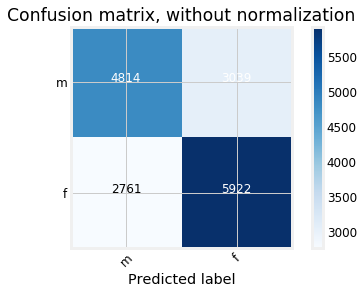

In [19]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes,
                      title='Confusion matrix, without normalization')

plt.show()


## Generate Binary Model

In [20]:
from core import Jiazz as J


J.compress(grid_search, 'gender_gramatical_esp')

'gender_gramatical_esp'

### Test Binary Model

In [21]:
from core import Jiazz as J
alg = J.load('gender_gramatical_esp')


In [22]:
# hombre
text = "Sin duda la Iglesia Católica debe hacer muchos cambios para evitar la pérdida constante de fieles (decenas de miles por año, solo en el Perú) y sobre todo la disminución de católicos practicantes. Frente a ello, un análisis problema-solución nos dice que el empoderamiento de los fieles mediante la lectura de la Biblia sería un cambio profundo pero realizable, que ayudaría mucho. Veamos."
print(J.score(alg, text))

# mujer
text = "@FernandoArmasCa LAMENTABLEMENTE NO ESTÁ POPY QUE EN TRES MINUTOS ACLARA LAS COSAS QUE NEGÓ ALAN EN SIETE HORAS."
print(J.score(alg, text))

# hombre
text = "Así explicó el inspector jefe de la Gürtel los 'indicios' de que Rajoy cobró de la 'caja B' del PP"
print(J.score(alg, text))

# mujer
text = "Una de las cosas que más impresionan de la cultura japonesa es la absoluta convicción de que fondo y forma no son cualidades excluyentes. Por ejemplo, importan tanto el respeto y la hospitalidad como los gestos con que se transmiten. Un banquete de su sofisticada comida obliga a que los alimentos no solo estén bien hechos sino que vengan en una exquisita vajilla. El grado de inclinación en una reverencia señala los distintos niveles de confianza con el otro. La forma significa, la forma importa."
print(J.score(alg, text))

# mujer
text = "Es q mande a los chicos a mi mamá para q no molesten en tu casa mientras iba a la clinica y los recogeria en la nocheeeee"
print(J.score(alg, text))


# mujer
text = "Es q mande a los chicos a mi mamá para q no molesten en tu casa mientras iba a la clinica y los recogeria en la nocheeeee"
print(J.score(alg, text))


# hombre
text = "ok ok chinita gracias deberas tenemos mucho trabajo, muchas reuniones esta semana como esta la bebe?"
print(J.score(alg, text))


# marcela
text = "Entonces todo se acaba sin que lo queramos. Por culpa de algo que nos ganaba en el conocimiento, sin saber manejarlo. Lo dejas todo por el sentimiento de no poder hacerme feliz. Sólo quiero que sepas que me haces más infeliz así y que yo simplemente moriré en el intento de no saber nada. Permíteme contarte que no te creo nada. Que confío en ti más que en nadie y sin embargo eres tú quien me engaña. "
print(J.score(alg, text))


# efrain
text = "El destino va escribiendo una historia  Que no nos imaginábamos ayer Dos fracciones de dos libros q medias Qué hoy se juntan por un mismo fin Fuimos esa opción que nunca planeamos Los errores nos trajeron hasta aquí Nunca te busqué y tú tampoco lo hiciste Pero estábamos ahí.  Ya ahora nos tenemos Reparando nuestros pedazos rotos Y ahora nos tenemos  reviviendo de a poco nuestros sueños Recuperando aquellas noches Desperdiciadas en otros cuerpos Reconstruyendo otro destino Dándole sentido a esta casualidad  Ya no hablemos de un pasado muy triste Pensemos en ser felices los dos  Y aunque mi tu primera opción no viste Hoy estás en mi habitación"
print(J.score(alg, text))


text = "Hola estoy caminando a la oficina me llamaron del colegio de mi hijo x un tema"
print(J.score(alg, text))

{'tag': 'm', 'scores': {'f': 0.1956601698335183, 'm': 0.8043398301664817}}
{'tag': 'f', 'scores': {'f': 0.8538121037490813, 'm': 0.14618789625091871}}
{'tag': 'm', 'scores': {'f': 0.20352109149194808, 'm': 0.7964789085080519}}
{'tag': 'm', 'scores': {'f': 0.4648750623472505, 'm': 0.5351249376527495}}
{'tag': 'f', 'scores': {'f': 0.5941132223282062, 'm': 0.4058867776717938}}
{'tag': 'f', 'scores': {'f': 0.5941132223282062, 'm': 0.4058867776717938}}
{'tag': 'm', 'scores': {'f': 0.13006906650797612, 'm': 0.8699309334920239}}
{'tag': 'f', 'scores': {'f': 0.94592522752528, 'm': 0.05407477247472003}}
{'tag': 'f', 'scores': {'f': 0.7669731076485183, 'm': 0.23302689235148163}}
{'tag': 'm', 'scores': {'f': 0.4687589411710906, 'm': 0.5312410588289094}}
